## Setup libs

In [25]:
### libs Setup ###
# %conda install --yes pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# %pip install timm 
# %conda install --yes conda-forge::matplotlib
# %conda install --yes seaborn -c conda-forge
# %conda install --yes scikit-learn -c conda-forge

In [45]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn

In [46]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Numpy version', np.__version__)
print('Pandas version', np.__version__)

System Version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
PyTorch version 2.3.1
Numpy version 1.26.4
Pandas version 1.26.4


## Class definition

In [47]:
class PsoriasisDataset(Dataset):
    def __init__(self, dir, transform=None):
        self.data = ImageFolder(dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def targets(self):
        return self.data.targets

    @property
    def classes(self):
        return self.data.classes

In [48]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [49]:
class SimplePsoriasisClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(SimplePsoriasisClassifier, self).__init__()
        # Where we define all the parts of the model.
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output.
        x = self.features(x)
        output = self.classifier(x)
        return output

In [50]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Setup dataset

In [51]:
# !rm -R datasets/.ipynb_checkpoints

In [52]:
imgnet_mean = [0.485, 0.456, 0.406]
imgnet_std = [0.229, 0.224, 0.225]

img_dimensions = (256, 256)
transform = transforms.Compose([
    # transforms.CenterCrop(img_dimensions),
    transforms.Resize(img_dimensions),
    transforms.ToTensor(),
    transforms.Normalize(imgnet_mean, imgnet_std)
])

dataset = PsoriasisDataset('datasets/')

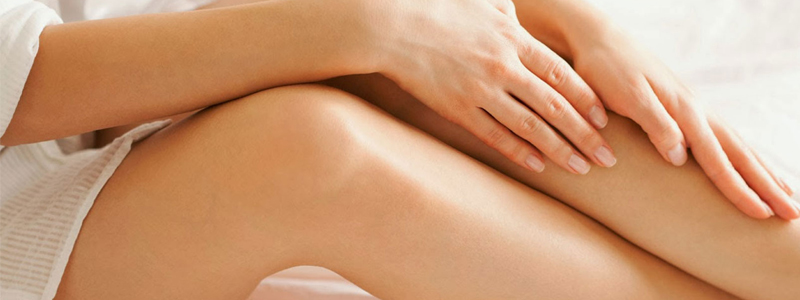

In [53]:
img_preview = dataset[0][0]
img_preview

In [54]:
dataset.classes

['normal', 'psoriase']

In [65]:
def holdout_partitioning(dataset, transform, train_ratio=0.70, validation_ratio=0.10, test_ratio=0.20):
    targets = dataset.targets
    
    train_idx, test_idx = train_test_split(
        np.arange(len(targets)),
        test_size=1-train_ratio,
        random_state=42,
        shuffle=True,
        stratify=targets
    )
    
    val_idx, test_idx = train_test_split(
        test_idx,
        test_size=test_ratio/(test_ratio + validation_ratio),
        random_state=42,
        shuffle=True,
        stratify=list(map(lambda x: targets[x], test_idx))
    )
    
    batch_size = 32
    num_workers = 0 # maybe 4 but I do not note any difference at all

    train_dataset = TransformedSubset(Subset(dataset, train_idx), transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=True)
    
    val_dataset = TransformedSubset(Subset(dataset, val_idx), transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=False)
    
    # test_dataset = TransformedSubset(Subset(dataset, test_idx), transform)
    test_dataset = PsoriasisDataset('new_test_datasets/', transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=False)

    return (train_loader, val_loader, test_loader)

In [66]:
train_loader, val_loader, test_loader = holdout_partitioning(dataset, transform)

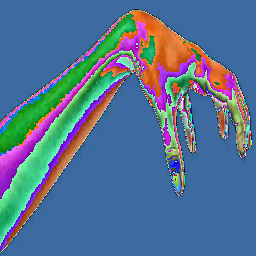

In [57]:
transforms.ToPILImage()(train_loader.dataset[10][0])


In [58]:
print(f'Train dataset length: {len(train_loader.dataset)} ( {round(len(train_loader.dataset)*100/len(dataset))} % )')
print(f'Validation dataset length: {len(val_loader.dataset)} ( {round(len(val_loader.dataset)*100/len(dataset))} % )')
print(f'Test dataset length: {len(test_loader.dataset)} ( {round(len(test_loader.dataset)*100/len(dataset))} % )')

Train dataset length: 1578 ( 70 % )
Validation dataset length: 225 ( 10 % )
Test dataset length: 126 ( 6 % )


## Train model

In [59]:
# To track the average training loss per epoch as the model trains
avg_train_losses = []
# To track the average validation loss per epoch as the model trains
avg_val_losses = [] 

model = SimplePsoriasisClassifier(num_classes=2)
device = torch.device('cuda:0')
model = model.to(device)

In [60]:
num_epochs = 100

# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Initialize EarlyStopping instance
early_stopping = EarlyStopping(patience=10, path='early_stopping_checkpoint.pt', verbose=True)

for epoch in range(num_epochs):
    # Set the model to train
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    avg_train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    avg_val_losses.append(val_loss)

    # Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

/home/natanael/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100 - Train loss: 0.11530123008662983, Validation loss: 0.03564598454369439
Validation loss decreased (inf --> 0.035646).  Saving model ...
Epoch 2/100 - Train loss: 0.04348817434845344, Validation loss: 0.12406995932250235
EarlyStopping counter: 1 out of 10
Epoch 3/100 - Train loss: 0.04107973585908593, Validation loss: 0.11077717079056634
EarlyStopping counter: 2 out of 10
Epoch 4/100 - Train loss: 0.0275349555085903, Validation loss: 0.05583505365583632
EarlyStopping counter: 3 out of 10
Epoch 5/100 - Train loss: 0.03623612002671445, Validation loss: 0.09386298033926221
EarlyStopping counter: 4 out of 10
Epoch 6/100 - Train loss: 0.024115616374817902, Validation loss: 0.04934475133816401
EarlyStopping counter: 5 out of 10
Epoch 7/100 - Train loss: 0.023969295334911354, Validation loss: 0.01945710049735175
Validation loss decreased (0.035646 --> 0.019457).  Saving model ...
Epoch 8/100 - Train loss: 0.01298167452473472, Validation loss: 0.04824077172411813
EarlyStopping count

In [61]:
# Load the last checkpoint with the best val loss
model.load_state_dict(torch.load(early_stopping.path))

<All keys matched successfully>

In [62]:
best_run_path = 'efficientnet_b0_best_run_checkpoint.pt'
try:
    checkpoint = torch.load(best_run_path)
    best_run_loss = checkpoint['loss']
except FileNotFoundError:
    best_run_loss = None

current_loss = -early_stopping.best_score
if best_run_loss is None or current_loss < best_run_loss:
    print(f'{current_loss} was a validation loss record. Saving this as the best run checkpoint.')
    this_run_data = {
        'model_state_dict': model.state_dict(),
        'avg_train_losses': avg_train_losses,
        'avg_val_losses': avg_val_losses,
        'loss': current_loss
    }
    torch.save(this_run_data, best_run_path)

In [ ]:
# Loading best model checkpoint

# model.load_state_dict(checkpoint['model_state_dict'])
# avg_train_losses = checkpoint['avg_train_losses']
# avg_val_losses = checkpoint['avg_val_losses']

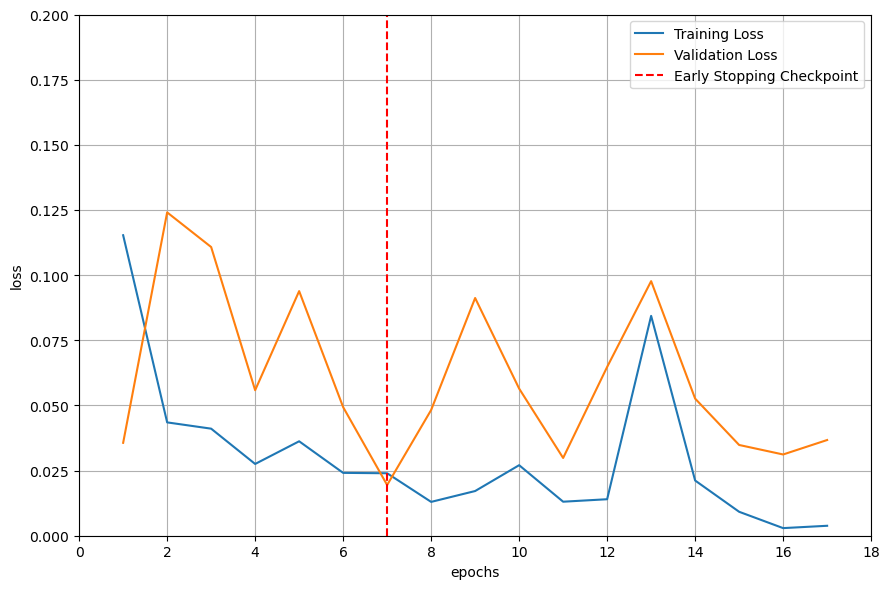

In [63]:
# Visualize the loss as the network trained
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_val_losses)+1), avg_val_losses, label='Validation Loss')

# Find position of lowest validation loss
minposs = avg_val_losses.index(min(avg_val_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.2) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Collect test metrics

In [67]:
# Predict using the model
def predict(model, test_img, device):
    model.eval()
    with torch.no_grad():
        test_img = test_img.to(device)
        outputs = model(test_img)
        test_preds = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
    return test_preds

y_pred = []
y_true = []

# Iterate over test data
for images, labels in test_loader:
    preds = predict(model, images, device)
    y_pred.extend(preds) # Save Prediction
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

In [68]:
classes = dataset.classes

# Build classification report
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
normal,0.979167,0.979167,0.979167,48.000
psoriase,0.987013,0.987013,0.987013,77.000
accuracy,0.984000,0.984000,0.984000,0.984
macro avg,0.983090,0.983090,0.983090,125.000
weighted avg,0.984000,0.984000,0.984000,125.000


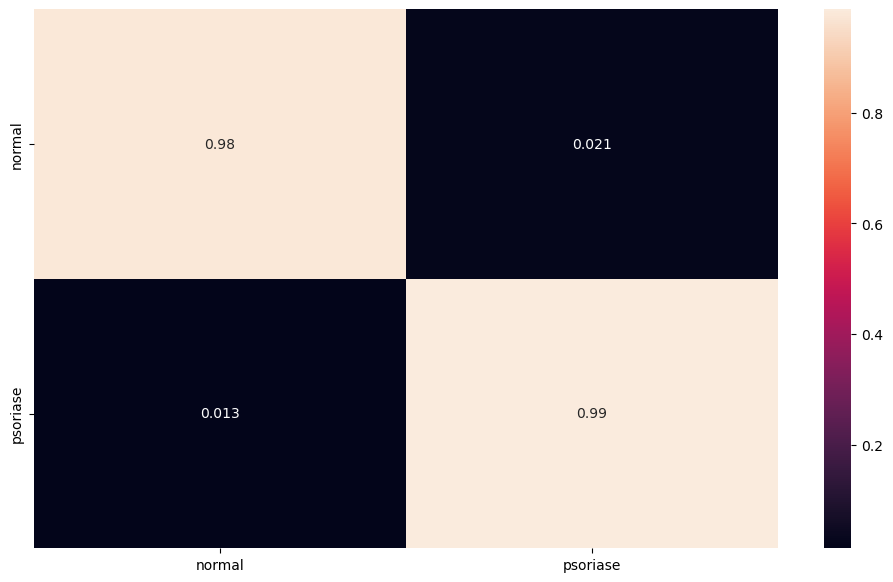

In [69]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
seaborn.heatmap(df_cm, annot=True)
plt.savefig('cf_matrix.png')
